In [1]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import optuna

import tensorflow as tf
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator

from keras import Input, Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dropout, Dense, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import EfficientNetB0

import warnings
warnings.filterwarnings("ignore")

In [2]:
class CFG:
    batch_size = 32
    img_height = 180
    img_width = 180
    hyper_tune = False

In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(2023)

In [4]:
train_normal_path = '/kaggle/input/chest-clahe/CHEST_CLAHE/train/normal'
train_pneu_path = '/kaggle/input/chest-clahe/CHEST_CLAHE/train/pneumonia'
train_normal_list_path = os.listdir(train_normal_path)
train_pneu_list_path = os.listdir(train_pneu_path)

valid_normal_path ='/kaggle/input/chest-clahe/CHEST_CLAHE/val/normal'
valid_pneu_path = '/kaggle/input/chest-clahe/CHEST_CLAHE/val/pneumonia'
valid_normal_list_path = os.listdir(valid_normal_path)
valid_pneu_list_path = os.listdir(valid_pneu_path)

test_normal_path = '/kaggle/input/chest-clahe/CHEST_CLAHE/test/normal'
test_pneu_path = '/kaggle/input/chest-clahe/CHEST_CLAHE/test/pneumonia'
test_normal_list_path = os.listdir(test_normal_path)
test_pneu_list_path = os.listdir(test_pneu_path)

In [5]:
# Create Data
len_train_normal = len(train_normal_list_path)
len_train_pneu = len(train_pneu_list_path)
len_valid_normal = len(valid_normal_list_path)
len_valid_pneu = len(valid_pneu_list_path)
len_test_normal = len(test_normal_list_path)
len_test_pneu = len(test_pneu_list_path)

len_normal = [len_train_normal, len_valid_normal, len_test_normal]
len_pneu = [len_train_pneu, len_valid_pneu, len_test_pneu]

# Create Subplots
data_split = ["Training", "Validation", "Testing"]
fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=data_split
)

for i in range(3):
    total = len_normal[i] + len_pneu[i]
    
    # Bar Chart
    fig.add_trace(
        go.Bar(
            x=["Normal", "Pneumonia"],
            y=[len_normal[i], len_pneu[i]],
            name=data_split[i],
            width=0.65,
            marker_color=["#1a7e96", "#ff4752"],
            text=[f"<b>{(value/total*100):.1f}%</b>" for value in [len_normal[i], len_pneu[i]]],
            textfont_size=13,
            textfont_color="white"
        ), row=1, col=i+1
    )

    # Update Axes
    fig.update_xaxes(ticks="outside", linecolor="Black", row=1, col=i+1)
    fig.update_yaxes(ticks="outside", linecolor="Black", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="Class Distribution", title_x=0.5, font_size=14,
    width=950, height=400,
    plot_bgcolor="White",
    showlegend=False
)

# Show
fig.show(renderer="iframe_connected")

In [6]:
def plot_chest_xray_image(path, list_path, title):
    plt.figure(figsize=(12, 6))
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        image = load_img(path + "/" + list_path[i])
        plt.imshow(image)
        plt.axis("off")
        plt.title(list_path[i], fontsize=10)
    plt.suptitle(title + " Class")

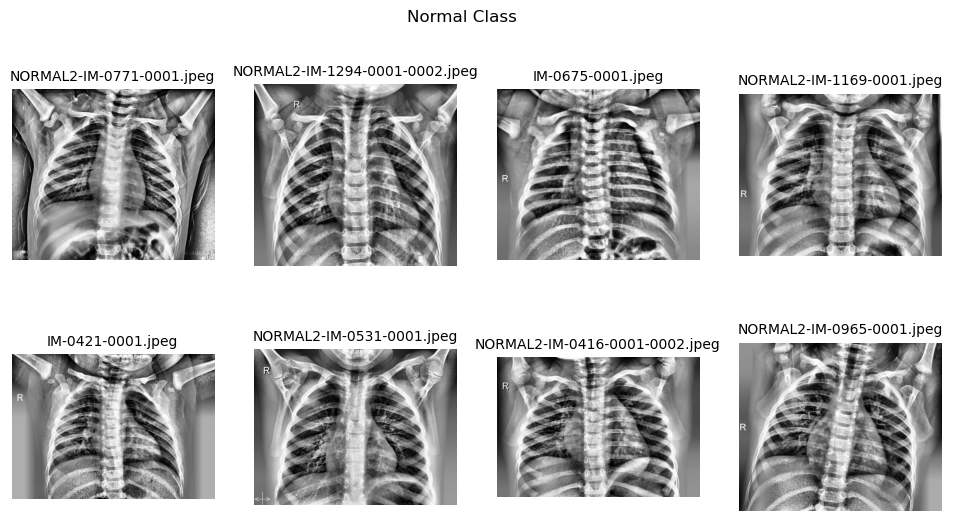

In [7]:
plot_chest_xray_image(train_normal_path, train_normal_list_path, title="Normal")


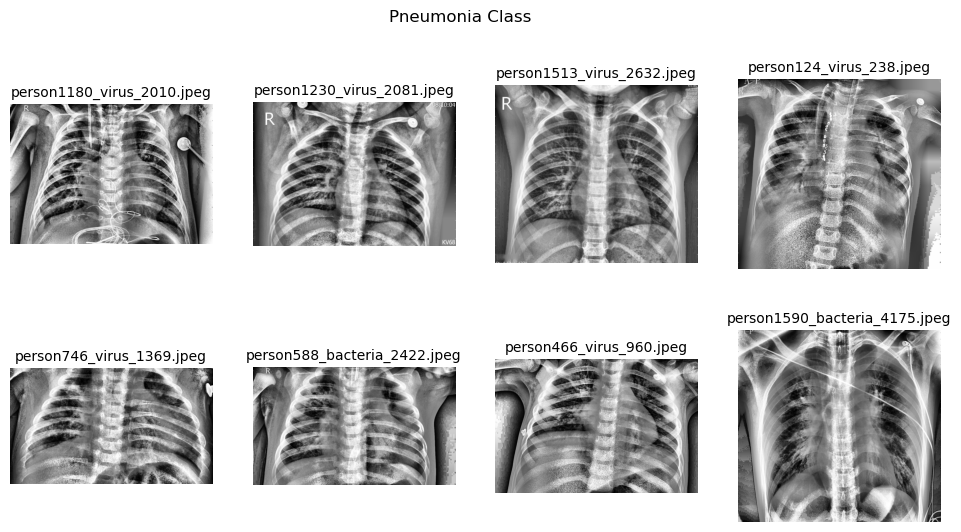

In [8]:
plot_chest_xray_image(train_pneu_path, train_pneu_list_path, title="Pneumonia")

In [9]:
# Data Augmentation
def data_augmentation():
    # Training Dataset
    TRAINING_DIR = '/kaggle/input/chest-clahe/CHEST_CLAHE/train'
    train_datagen = ImageDataGenerator(
        rescale=1/255.,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.15
    )
    train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size,
        class_mode="binary",
        shuffle=True,
        subset="training"
    )

    # Validation Dataset
    validation_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size,
        class_mode='binary',
        shuffle=False,
        subset="validation"
    )

    # Testing Dataset
    TESTING_DIR = '/kaggle/input/chest-clahe/CHEST_CLAHE/test'
    test_datagen = ImageDataGenerator(rescale=1./255.)
    test_generator = test_datagen.flow_from_directory(
        TESTING_DIR,
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=1,
        class_mode='binary',
    )
    
    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = data_augmentation()

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
# Create the Model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(CFG.img_height, CFG.img_width, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the Model
model.compile(
    optimizer=RMSprop(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=['acc', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall')
            ]
)

# Model Summary
display(model.summary())

# Create Callback
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=3
)

model_checkpoint = ModelCheckpoint(
    "CNN_model.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)

callbacks = [early_stopping, model_checkpoint]

# Train Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=len(train_generator)//4,
    callbacks=callbacks,
)

# Evaluate on Testing data
scores = model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("Evaluate ",model.metrics_names[1], scores[1]*100))
print("%s%s: %.2f%%" % ("Evaluate ",model.metrics_names[2], scores[2]*100))
print("%s%s: %.2f%%" % ("Evaluate ",model.metrics_names[3], scores[3]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0

None

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.6174 - acc: 0.7244 - precision: 0.7495 - recall: 0.9463
Epoch 1: val_loss improved from inf to 0.57650, saving model to CNN_model.h5
34/34 [==============================] - 93s 3s/step - loss: 0.6174 - acc: 0.7244 - precision: 0.7495 - recall: 0.9463 - val_loss: 0.5765 - val_acc: 0.7430 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.5567 - acc: 0.7616 - precision: 0.7616 - recall: 1.0000
Epoch 2: val_loss did not improve from 0.57650
34/34 [==============================] - 88s 3s/step - loss: 0.5567 - acc: 0.7616 - precision: 0.7616 - recall: 1.0000 - val_loss: 0.7702 - val_acc: 0.7430 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.5735 - acc: 0.7482 - precision: 0.7482 - recall: 1.0000
Epoch 3: val_loss improved from 0.57650 to 0.56896, saving model to CNN_model.h5
34/34 [========

In [11]:
# Visualize Training Results

# Create Subplot
fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=["Model Loss", "Model Accuracy", "Model Precision", "Model Recall"], 
)

# Loss Plot
loss = history.history['loss']
val_loss = history.history['val_loss']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color="Blue", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Blue", width=1.5),
        name="Training Loss"
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color="Orange", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Orange", width=1.5),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = history.history['acc']
val_acc = history.history['val_acc']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1), y=acc,
        mode="markers+lines",
        marker=dict(
            color="Blue", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Blue", width=1.5),
        name="Training Accuracy"
    ), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1), y=val_acc,
        mode="markers+lines",
        marker=dict(
            color="Orange", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Orange", width=1.5),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Precision Plot
precision = history.history['precision']
val_precision = history.history['val_precision']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(precision)+1), y=precision,
        mode="markers+lines",
        marker=dict(
            color="Blue", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Blue", width=1.5),
        name="Training Precision"
    ), row=2, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_precision)+1), y=val_precision,
        mode="markers+lines",
        marker=dict(
            color="Orange", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Orange", width=1.5),
        name="Validation Precision"
    ), row=2, col=1
)

# Recall Plot
recall = history.history['recall']
val_recall = history.history['val_recall']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(recall)+1), y=recall,
        mode="markers+lines",
        marker=dict(
            color="Blue", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Blue", width=1.5),
        name="Training Recall"
    ), row=2, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_recall)+1), y=val_recall,
        mode="markers+lines",
        marker=dict(
            color="Orange", size=6,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color="Orange", width=1.5),
        name="Validation Recall"
    ), row=2, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=2, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=2, col=2)
fig.update_yaxes(title="BCE Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Precision", linecolor="Black", ticks="outside", row=2, col=1)
fig.update_yaxes(title="Recall", linecolor="Black", ticks="outside", row=2, col=2)

# Update Layout
fig.update_layout(
    title="Training and Validation Results", title_x=0.5,
    width=950, height=800,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

In [12]:
if(CFG.hyper_tune):
    # Define the hyperparameter search space
    def objective(trial):
        seed_everything(2023)
        model = Sequential()
        try:
            # Tune the number of convolutional layers
            n_layers = trial.suggest_int('n_layers', 3, 6)

            # Tune the number of filters and size of the filters for each convolutional layer
            for i in range(n_layers):
                n_filters = trial.suggest_int(f'n_filters_{i}', 32, 128)
                kernel_size = trial.suggest_int(f'kernel_size_{i}', 3, 5)
                if i == 0:
                    model.add(Conv2D(n_filters, kernel_size=kernel_size, activation='relu', input_shape=(CFG.img_height, CFG.img_width, 3)))
                else:
                    model.add(Conv2D(n_filters, kernel_size=kernel_size, activation='relu'))

                # Tune the pooling method for each convolutional layer
                pooling = trial.suggest_categorical(f'pooling_{i}', ['max', 'avg'])
                if pooling == 'max':
                    model.add(MaxPooling2D(pool_size=(2, 2)))
                else:
                    model.add(AveragePooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            # Tune the number of neurons in the fully connected layer after the convolutional layers
            n_neurons_fc1 = trial.suggest_int('n_neurons_fc1', 64, 512)
            model.add(Dense(n_neurons_fc1, activation='relu'))

            # Tune the dropout rate
            dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
            model.add(Dropout(dropout_rate))

            model.add(Dense(1, activation='sigmoid'))

            optimizer = RMSprop(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True))

            model.compile(optimizer=optimizer,
                          loss='binary_crossentropy',
                          metrics=['acc', 
                                 tf.keras.metrics.Precision(name='precision'), 
                                 tf.keras.metrics.Recall(name='recall')
                                  ]
            )

            display(model.summary())

        except Exception as e:
            print(f"Error during model building or training: {e}")
            score = 0.0
            return score

        # Create Dataset
        train_generator, validation_generator, test_generator = data_augmentation()

        # Create Callback
        early_stopping = EarlyStopping(
            monitor="val_loss",
            mode="min",
            verbose=1,
            patience=3
        )
        callbacks = [early_stopping]

        # Train Model
        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=20,
            steps_per_epoch=len(train_generator)//4,
            callbacks=callbacks,
        )

        # Evaluate on Testing data
        scores = model.evaluate(test_generator)

        return scores[1]

    # Run the hyperparameter search
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=2023))
    study.optimize(objective, n_trials=20)

    # Print the best hyperparameters
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)

In [13]:
# Best Parameters
params = {'n_layers': 3, 
          'n_filters_0': 73, 
          'kernel_size_0': 5, 
          'pooling_0': 'max', 
          'n_filters_1': 114, 
          'kernel_size_1': 4, 
          'pooling_1': 'max', 
          'n_filters_2': 114, 
          'kernel_size_2': 5, 
          'pooling_2': 'avg', 
          'n_neurons_fc1': 239, 
          'dropout_rate': 0.11514078475381184, 
          'learning_rate': 0.00010254312064434285
}

In [14]:
seed_everything(2023)

# Create the Model
hp_model = Sequential([
    Conv2D(params['n_filters_0'], kernel_size=params['kernel_size_0'], activation='relu', input_shape=(CFG.img_height, CFG.img_width, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(params['n_filters_1'], kernel_size=params['kernel_size_1'], activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(params['n_filters_2'], kernel_size=params['kernel_size_2'], activation='relu'),
    AveragePooling2D(2, 2),
    
    Flatten(),
    Dense(params['n_neurons_fc1'], activation='relu'),
    Dropout(params['dropout_rate']),
    Dense(1, activation='sigmoid')
])

# Compile the Model
hp_model.compile(
    optimizer=RMSprop(learning_rate=params['learning_rate']), 
    loss='binary_crossentropy', 
    metrics=['acc', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall')
            ]
)

# Model Summary
display(hp_model.summary())

# Create Dataset
train_generator, validation_generator, test_generator = data_augmentation()

# Create Callback
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=3
)

model_checkpoint = ModelCheckpoint(
    "CNN_model_after_HP.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)

callbacks = [early_stopping, model_checkpoint]

# Train Model
hp_history = hp_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=len(train_generator)//4,
    callbacks=callbacks,
)

# Evaluate on Testing data
scores = hp_model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("Evaluate ",hp_model.metrics_names[1], scores[1]*100))
print("%s%s: %.2f%%" % ("Evaluate ",hp_model.metrics_names[2], scores[2]*100))
print("%s%s: %.2f%%" % ("Evaluate ",hp_model.metrics_names[3], scores[3]*100))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 176, 176, 73)      5548      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 88, 88, 73)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 85, 85, 114)       133266    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 42, 42, 114)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 38, 38, 114)       325014    
                                                                 
 average_pooling2d (AverageP  (None, 19, 19, 114)     

None

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.5909 - acc: 0.7371 - precision: 0.7543 - recall: 0.9645
Epoch 1: val_loss improved from inf to 0.56439, saving model to CNN_model_after_HP.h5
34/34 [==============================] - 205s 6s/step - loss: 0.5909 - acc: 0.7371 - precision: 0.7543 - recall: 0.9645 - val_loss: 0.5644 - val_acc: 0.7430 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.5588 - acc: 0.7402 - precision: 0.7425 - recall: 0.9937
Epoch 2: val_loss improved from 0.56439 to 0.50501, saving model to CNN_model_after_HP.h5
34/34 [==============================] - 240s 7s/step - loss: 0.5588 - acc: 0.7402 - precision: 0.7425 - recall: 0.9937 - val_loss: 0.5050 - val_acc: 0.7442 - val_precision: 0.7439 - val_recall: 1.0000
Epoch 3/20
34/34 [==========================